In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from utils import MetricLearningTransforms
import torch.nn as nn
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

c:\Users\jordi\anaconda3\envs\python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
        "IMG_WIDTH": 224,
        "IMG_HEIGHT": 224,
        "batch_size": 32,
        "learning_rate": 1e-4,
        "n_neighbors": 5,
        'epochs': 10,
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "neg_margin": 0.8,
        "pos_margin": 0.2
    }


torch.manual_seed(123); # seed for reproductibility

In [3]:
transform = MetricLearningTransforms(config, mode='test')

dataset_s01 = ImageFolder("metric_cars_dataset/S01", transform=transform)
dataset_s03 = ImageFolder("metric_cars_dataset/S03", transform=transform)
dataset_s04 = ImageFolder("metric_cars_dataset/S04", transform=transform)

s01_loader = DataLoader(dataset_s01, shuffle=False, batch_size=config["batch_size"])
s03_loader = DataLoader(dataset_s03, shuffle=False, batch_size=config["batch_size"])
s04_loader = DataLoader(dataset_s04, shuffle=False, batch_size=config["batch_size"])

In [4]:
class Net(torch.nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')
            self.model.fc = nn.Identity()
            
        def forward(self, x):
            return self.model(x)
        
model = Net()
model.load_state_dict(torch.load(f'./sweep_weights/siamese_model_6.pth', map_location=config['device']))
model.to(config['device']);

Using cache found in C:\Users\jordi/.cache\torch\hub\pytorch_vision_v0.10.0


In [5]:
def extract_features(loader, model, device):
    model.eval()
    with torch.no_grad():    
        features, labels = [], []
        for img, label in tqdm(loader, total=len(loader), desc='Extracting features'):
            features.append(model(img.to(device)).cpu().detach().numpy())
            labels.append(label)
    return np.concatenate(features).astype('float32'), np.concatenate(labels)
    
def reduce(data, mode):
    if mode == 'TSNE':
        reduced_data = TSNE(n_components=2, learning_rate='auto',
                    init='pca', perplexity=3).fit_transform(data)
    
    elif mode=='UMAP':
        reduced_data = umap.UMAP(n_components=2, n_neighbors=5).fit_transform(data)
    
    elif mode=='PCA':
        reduced_data = PCA(n_components=2).fit_transform(data)
    
    else:
        raise ValueError('Invalid mode. Please use one of the following: TSNE, UMAP, PCA')

    return reduced_data

In [6]:
embeddings_s01, labels_s01 = extract_features(s01_loader, model, config["device"])
embeddings_s03, labels_s03 = extract_features(s03_loader, model, config["device"])
embeddings_s04, labels_s04 = extract_features(s04_loader, model, config["device"])

Extracting features: 100%|██████████| 95/95 [00:22<00:00,  4.17it/s]


In [7]:
s01_idx_to_class = {v: k for k, v in dataset_s01.class_to_idx.items()}
s03_idx_to_class = {v: k for k, v in dataset_s03.class_to_idx.items()}
s04_idx_to_class = {v: k for k, v in dataset_s04.class_to_idx.items()}

def map_labels(labels, idx_to_class):
    return np.vectorize(idx_to_class.__getitem__)(labels)

labels_all = np.concatenate([
    map_labels(labels_s01, s01_idx_to_class),
    map_labels(labels_s03, s03_idx_to_class),
    map_labels(labels_s04, s04_idx_to_class)
    ])
embeddings_all = np.concatenate([embeddings_s01, embeddings_s03, embeddings_s04])

c:\Users\jordi\anaconda3\envs\python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


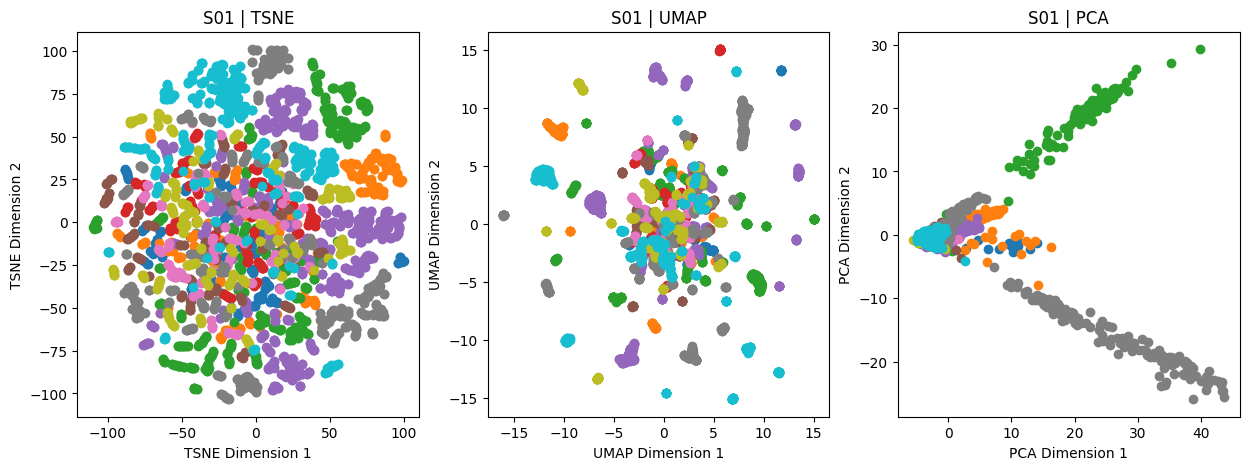

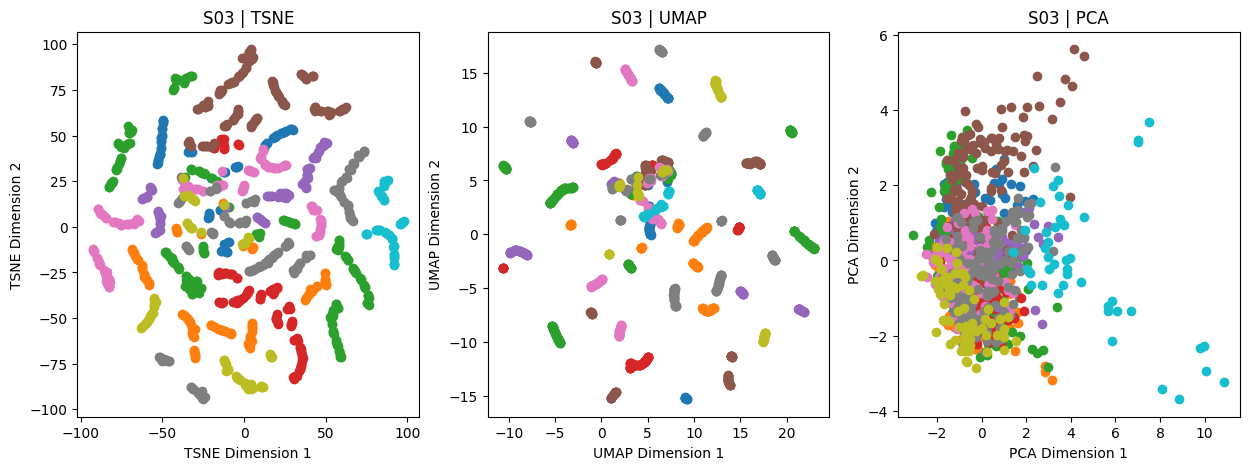

c:\Users\jordi\anaconda3\envs\python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


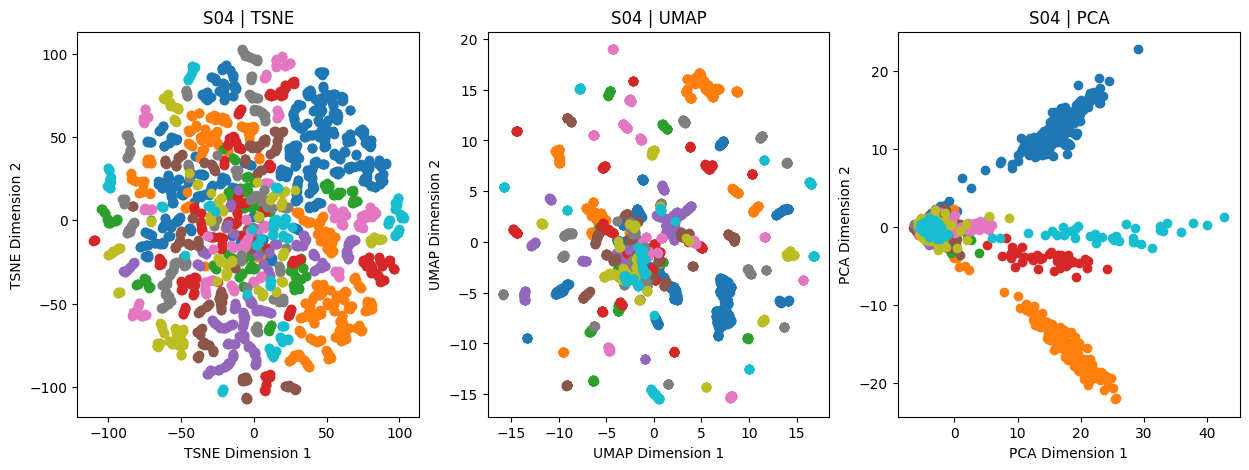

c:\Users\jordi\anaconda3\envs\python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


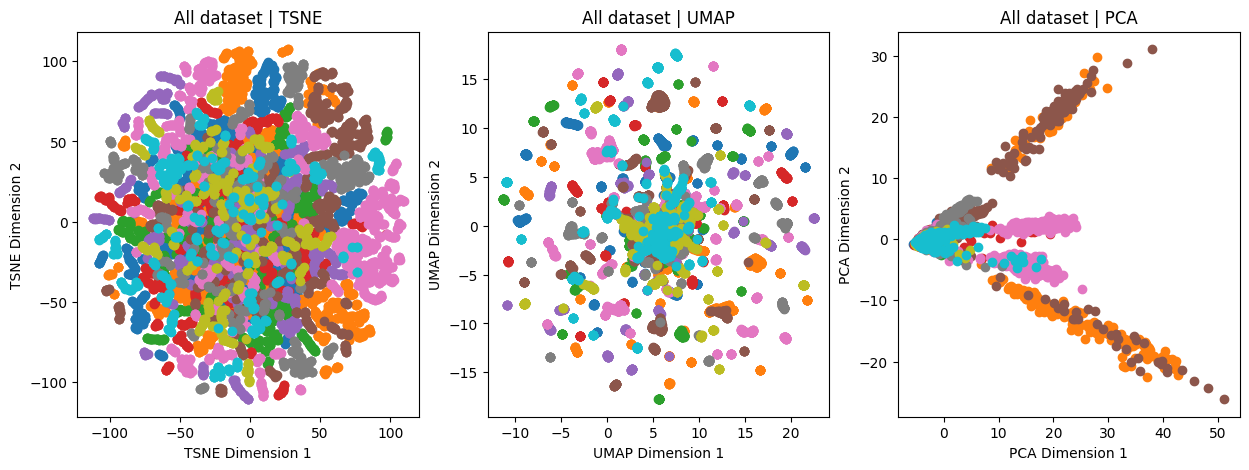

In [11]:
for i, (embeddings, labels, name) in enumerate([(embeddings_s01, labels_s01, "S01"), (embeddings_s03, labels_s03, "S03"), (embeddings_s04, labels_s04, "S04"), (embeddings_all, labels_all, "All dataset")]):
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
    for j, mode in enumerate(["TSNE", "UMAP", "PCA"]):
        reduced_embedding = reduce(embeddings, mode)

        colormap = plt.get_cmap('tab10')
        classes = list(set(labels))
        class_colors = [colormap(i/len(classes)) for i in range(len(classes))]

        for k, label in enumerate(classes):
            mask = np.array([l == label for l in labels])
            ax[j].scatter(reduced_embedding[mask, 0], reduced_embedding[mask, 1], color=class_colors[k])

        ax[j].set_title(f'{name} | {mode}')
        ax[j].set_xlabel(f'{mode} Dimension 1')
        ax[j].set_ylabel(f'{mode} Dimension 2')
    plt.show()

c:\Users\jordi\anaconda3\envs\python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jordi\anaconda3\envs\python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\jordi\anaconda3\envs\python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


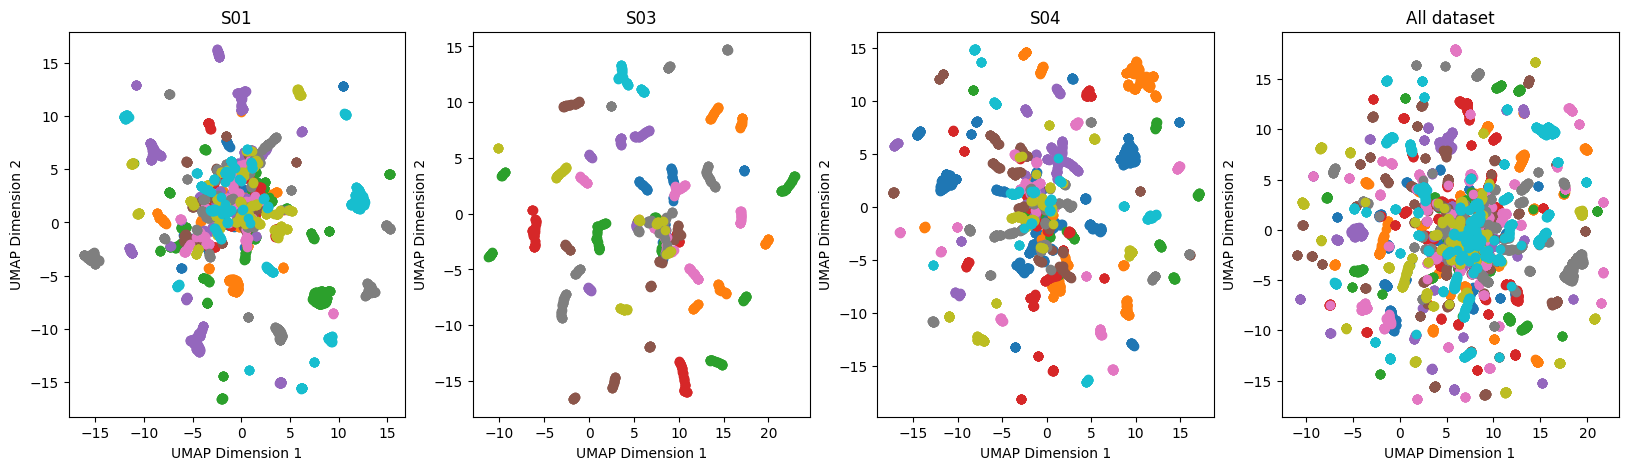

In [ ]:
mode = "UMAP"
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))
for i, (embeddings, labels, name) in enumerate([(embeddings_s01, labels_s01, "S01"), (embeddings_s03, labels_s03, "S03"), (embeddings_s04, labels_s04, "S04"), (embeddings_all, labels_all, "All dataset")]):
    reduced_embedding = reduce(embeddings, mode)
    colormap = plt.get_cmap('tab10')
    classes = list(set(labels))
    class_colors = [colormap(i/len(classes)) for i in range(len(classes))]

    for j, label in enumerate(classes):
        mask = np.array([l == label for l in labels])
        ax[i].scatter(reduced_embedding[mask, 0], reduced_embedding[mask, 1], color=class_colors[j])

    ax[i].set_title(f'{name}')
    ax[i].set_xlabel(f'{mode} Dimension 1')
    ax[i].set_ylabel(f'{mode} Dimension 2')
plt.show()

### Mean distance between classes:

In [ ]:
dataset_centers = []
for label in np.unique(labels_all):
    label_embeddings = embeddings_all[labels_all == label]
    label_center = label_embeddings.sum(axis=0) / label_embeddings.shape[0]
    dataset_centers.append(label_center)

In [ ]:
from itertools import combinations
from numpy.linalg import norm

distances = [norm(p1 - p2, ord=2) for p1, p2 in combinations(dataset_centers, 2)]
np.mean(distances)

7.744051